<a href="https://colab.research.google.com/github/Ofiregev/Final_Project-FetalCns/blob/main/Fetal_Cns_Final_reg_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import KFold
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

print("Part 1 has done")

Mounted at /content/drive
Part 1 has done


In [18]:

# Determine the available hardware (CPU or GPU) and set the PyTorch device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [36]:
# Read the list of images from the CSV file
train_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC.csv"
train_csv_df = pd.read_csv(train_csv)
print(train_csv_df.head())


     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81


In [73]:
# Compute min and max values of the head circumference
min_hc = train_csv_df['head circumference (mm)'].min()
max_hc = train_csv_df['head circumference (mm)'].max()
print(min_hc, max_hc)

# Normalize the labels in the dataset
train_csv_df['Normalized_HC'] = (train_csv_df['head circumference (mm)'] - min_hc) / (max_hc - min_hc)
output_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC_no_index.csv"
train_csv_df.to_csv(output_csv, index=False)
print(train_csv_df.head())


44.3 346.4
     filename  pixel size(mm)  head circumference (mm)  Normalized_HC
0  000_HC.png        0.069136                    44.30       0.000000
1  001_HC.png        0.089659                    56.81       0.041410
2  002_HC.png        0.062033                    68.75       0.080933
3  003_HC.png        0.091291                    69.00       0.081761
4  004_HC.png        0.061240                    59.81       0.051341


In [105]:


# Update CustomDataset class to use normalized labels
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        label = self.data_frame.iloc[idx, 3]  # Assuming the fourth column is the normalized label
        return image, label



In [106]:
train_csv_df.head()
len(train_csv_df)

999

In [139]:
# Part 3: Define Transforms and Create Dataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale images
])

# Create the dataset with the updated CSV
train_dataset = CustomDataset(csv_file=output_csv,
                              root_dir="/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/",
                              transform=transform)

In [161]:
# Part 4: Create DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [162]:
class Model(nn.Module):
    def __init__(self, input_channels=1, input_size=64):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)  # Additional Convolutional Layer
        self.pool = nn.MaxPool2d(2, 2)
        conv_output_size = input_size // 2 // 2 // 2 // 2 // 2  # Adjusted for additional pooling layers
        self.fc1 = nn.Linear(512 * conv_output_size * conv_output_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.3)  # Increased Dropout Rate
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.pool(F.relu(self.conv5(x)))  # Additional Convolutional Layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [163]:
model = Model(input_channels=1, input_size=64)
model.to(device)

Model(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256,

In [164]:
# Part 6: Define Training Parameters and Optimizer
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


In [165]:
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

def train(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float().to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
        scheduler.step()  # Step the scheduler

    plot_loss(train_losses, val_losses, epochs)

def plot_loss(train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [166]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_losses = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())

    fold_avg_val_loss = np.mean(val_losses)
    return fold_avg_val_loss


Fold 1
Epoch 1, Train Loss: 1.1637, Validation Loss: 0.0490
Epoch 2, Train Loss: 0.0453, Validation Loss: 0.0355
Epoch 3, Train Loss: 0.0428, Validation Loss: 0.0308
Epoch 4, Train Loss: 0.0473, Validation Loss: 0.0275
Epoch 5, Train Loss: 0.0346, Validation Loss: 0.0246
Epoch 6, Train Loss: 0.0325, Validation Loss: 0.0187
Epoch 7, Train Loss: 0.0228, Validation Loss: 0.0183
Epoch 8, Train Loss: 0.0260, Validation Loss: 0.0643


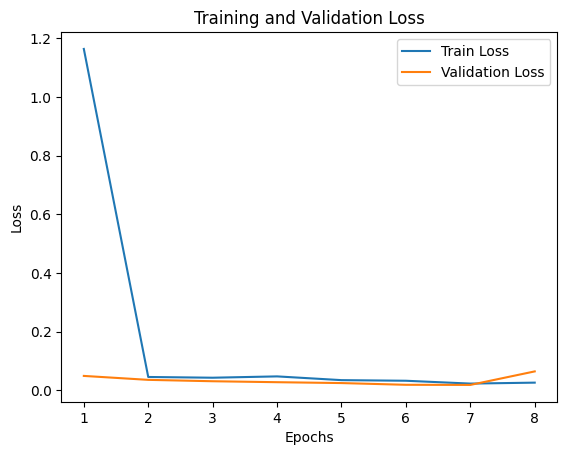

Fold 1 Validation Loss: 0.0623
Fold 2
Epoch 1, Train Loss: 0.3820, Validation Loss: 0.0385
Epoch 2, Train Loss: 0.0397, Validation Loss: 0.0353
Epoch 3, Train Loss: 0.0349, Validation Loss: 0.0301
Epoch 4, Train Loss: 0.0300, Validation Loss: 0.0210
Epoch 5, Train Loss: 0.0292, Validation Loss: 0.0321
Epoch 6, Train Loss: 0.0252, Validation Loss: 0.0226
Epoch 7, Train Loss: 0.0210, Validation Loss: 0.0481
Epoch 8, Train Loss: 0.0224, Validation Loss: 0.0185


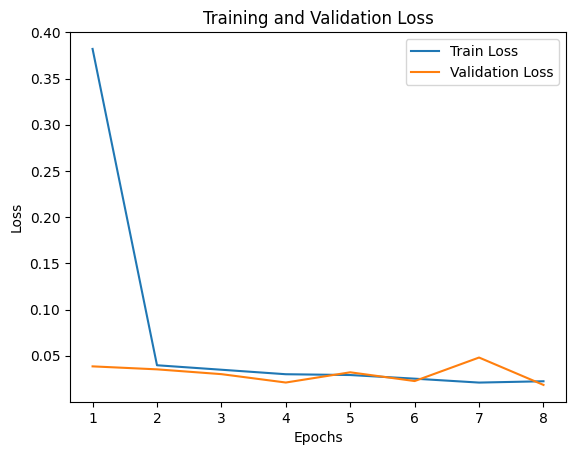

Fold 2 Validation Loss: 0.0178
Fold 3
Epoch 1, Train Loss: 0.4236, Validation Loss: 0.0362
Epoch 2, Train Loss: 0.0492, Validation Loss: 0.0377
Epoch 3, Train Loss: 0.0405, Validation Loss: 0.0310
Epoch 4, Train Loss: 0.0416, Validation Loss: 0.0350
Epoch 5, Train Loss: 0.0354, Validation Loss: 0.0242
Epoch 6, Train Loss: 0.0320, Validation Loss: 0.0287
Epoch 7, Train Loss: 0.0273, Validation Loss: 0.0171
Epoch 8, Train Loss: 0.0234, Validation Loss: 0.0240


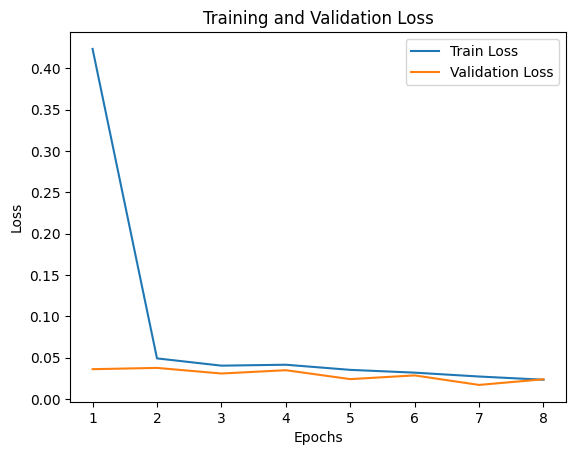

Fold 3 Validation Loss: 0.0220
Average Evaluation Metric: 0.0340


In [168]:
from torch.utils.data import SubsetRandomSampler

k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)
evaluation_metrics = []
epochs = 8
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def reset_model(model_class, *args, **kwargs):
    model = model_class(*args, **kwargs)
    return model

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold_idx + 1}")
    print("=========")

    # Reset the model and optimizer
    model = reset_model(Model, input_channels=1, input_size=64).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Create data loaders using SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader_fold = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    val_loader_fold = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

    # Train and evaluate
    train(model, train_loader_fold, val_loader_fold, optimizer, scheduler, criterion, epochs, device)
    fold_avg_val_loss = evaluate(model, val_loader_fold, criterion, device)
    evaluation_metrics.append(fold_avg_val_loss)

    print(f"Fold {fold_idx + 1} Validation Loss: {fold_avg_val_loss:.4f}")
    print("=========")

average_metric = np.mean(evaluation_metrics)
print(f"Average Evaluation Metric: {average_metric:.4f}")

In [169]:
# Part 8: Save the trained model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
torch.save(model.state_dict(), model_path)
print("Model saved successfully!")

Model saved successfully!


In [170]:
# # Load the trained model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
model = Model(input_channels=1, input_size=64)
model.load_state_dict(torch.load(model_path))
model.eval()

Model(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256,

In [171]:
def predict_head_circumference(image_path, model, min_hc, max_hc):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor.float())

    predicted_normalized_hc = output.item()
    predicted_hc = predicted_normalized_hc * (max_hc - min_hc) + min_hc  # De-normalize the prediction
    return predicted_hc


In [182]:
# This part checks the percentage of images with specific error result
num_images_to_test = len(train_csv_df)
indices = range(num_images_to_test)  # Generate a sequence of indices from 0 to num_images_to_test-1

# Initialize a list to store the absolute errors
absolute_errors = []
counter = 0
error_parameter = 5
# Open a file to write the results
with open("results.txt", "w") as file:
    # Loop through the selected images
    for idx in indices:

        image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", train_csv_df.iloc[idx, 0])
        ground_truth_circumference = train_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels

        # Call the function to predict head circumference from the image
        predicted_circumference = predict_head_circumference(image_path, model, min_hc, max_hc)

        # Calculate the absolute error and add it to the list
        absolute_error = abs(predicted_circumference - ground_truth_circumference)
        absolute_errors.append(absolute_error)

        if absolute_error < error_parameter:
            file.write(f"Image: {image_path}\n")
            file.write(f"Predicted Head Circumference: {predicted_circumference}\n")
            file.write(f"Ground Truth Head Circumference: {ground_truth_circumference}\n")
            file.write(f"Absolute Error: {absolute_error}\n")
            file.write("\n")
            file.write("****************************\n")
            counter += 1

    # Write the counter and percentage to the file
    file.write(f"Total Images with Error < 5: {counter}\n")
    file.write(f"Percentage: {counter / num_images_to_test * 100:.2f}%\n")
    print(f"Total Images with Error < 5: {counter}\n")
    print(f"Percentage: {counter / num_images_to_test * 100:.2f}%\n")


Total Images with Error < 5: 129

Percentage: 12.91%



In [178]:
# # Choose 10 random indices from the dataset
# num_images_to_test = 500
# random_indices = np.random.choice(len(train_csv_df), size=num_images_to_test, replace=False)

# # Initialize a list to store the absolute errors
# absolute_errors = []
# # Loop through the selected images
# for idx in random_indices:

#     image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", train_csv_df.iloc[idx, 0])
#     ground_truth_circumference = train_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels

#     # Call the function to predict head circumference from the image
#     predicted_circumference = predict_head_circumference(image_path, model, min_hc, max_hc)

#     # Calculate the absolute error and add it to the list
#     absolute_error = abs(predicted_circumference - ground_truth_circumference)
#     absolute_errors.append(absolute_error)


#     # Print the predicted and ground truth head circumferences
#     print("Image:", image_path)
#     print("Predicted Head Circumference:", predicted_circumference)
#     print("Ground Truth Head Circumference:", ground_truth_circumference)
#     print("Absolute Error:", absolute_error)
#     print("==============================================")

# # Calculate the average absolute error
# average_absolute_error = sum(absolute_errors) / len(absolute_errors)
# print("Average Absolute Error:", average_absolute_error)


Image: /content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/377_HC.png
Predicted Head Circumference: 175.01974385380743
Ground Truth Head Circumference: 172.26
Absolute Error: 2.7597438538074357

****************************
Image: /content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/043_HC.png
Predicted Head Circumference: 69.2948203265667
Ground Truth Head Circumference: 69.94
Absolute Error: 0.6451796734333044

****************************
Image: /content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/248_HC.png
Predicted Head Circumference: 171.93811863660812
Ground Truth Head Circumference: 170.35
Absolute Error: 1.5881186366081295

****************************
Image: /content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/054_HC.png
Predicted Head Circumference: 74.70772601887583
Ground Truth Head Circumference: 73.03
Absolute Error: 1.6777260188758305

****************************
Image: /content/drive/MyDrive/FinalPr

In [173]:
# # Path for the new image
new_image_path = "/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/001_HC.png"
# Call the function to predict head circumference from the new image
predicted_circumference = predict_head_circumference(new_image_path, model, min_hc, max_hc)

print("Predicted Head Circumference:", predicted_circumference)


Predicted Head Circumference: 76.07705087214708
